# 0. Setup

In [16]:
# Import Packages
import numpy as np
import pandana as pdna
import geopandas as gpd
import pandas as pd
import shapely
from shapely import wkt
import statistics
import matplotlib.pyplot as plt
import zipfile

# Import sklearn packages
from sklearn.model_selection import train_test_split

In [17]:
# Ignore Warnings
import warnings

import warnings
warnings.filterwarnings("ignore")

In [18]:
# Assumptions
rs=42

sd_thresh = 1

# 1. Import and split data

## 1.1 Import

In [19]:
# Import Data
data_11 = pd.read_csv('C:\\Users\\wthac\\OneDrive\\Desktop\\Value Australia\\Data\\ML Gentrification Prediction\\Inputs\\Cleaned Dataset/Data_11_SEIFA_final.csv')
data_16 = pd.read_csv('C:\\Users\\wthac\\OneDrive\\Desktop\\Value Australia\\Data\\ML Gentrification Prediction\\Inputs\\Cleaned Dataset/Data_16_SEIFA_final.csv')

## 1.2 Data split (80/20 ratio)

In [20]:
# Split data into training/test/validation
train, test = train_test_split(data_11, test_size = 0.2, random_state = rs)

# Split into X and Y
x_train = train.iloc[:,1:-2]  # ''-2' column is 'irsad score 2011' - for comparison of change in rank, not for modelling
y_train = train.iloc[:,-1]

x_test = test.iloc[:,1:-2]  
y_test = test.iloc[:,-1]

# 2. Build Simple Linear Regression to compare model performance

# 2.1 Fit model

In [21]:
# Import package:
from sklearn.linear_model import LinearRegression

# Fit model
lm = LinearRegression().fit(x_train, y_train)

# Fir prediction to test dataset
y_pred_lm = lm.predict(x_test)

## 2.2 Evaluate performance based on SEIFA score

In [22]:
# Import Regression metrics
from sklearn.metrics import (mean_absolute_error as mae, mean_squared_error as mse, 
                             explained_variance_score as evs, r2_score as r2)

def mape(Y_actual,Y_Predicted):
    mape = np.mean(np.abs((Y_actual - Y_Predicted)/Y_actual))*100
    return mape

# Evaluate Model performanc metrics
mae_lm = mae(y_test, y_pred_lm)
mse_lm = mse(y_test, y_pred_lm)
evs_lm = evs(y_test, y_pred_lm)
r2_lm = r2(y_test, y_pred_lm)
mape_lm = mape(y_test, y_pred_lm)

print(f"mae_lm: {mae_lm}, \nmse_lm: {mse_lm}, \nevs_lm: {evs_lm}, \nr2_lm: {r2_lm}, \nmape_lm: {mape_lm}")

mae_lm: 22.76598570967739, 
mse_lm: 948.5748521333138, 
evs_lm: 0.9127090115310499, 
r2_lm: 0.9127075848255612, 
mape_lm: 2.260751967462526


## 2.3 Evaluate model performance based on SEIFA rank

In [23]:
test_lm = test

## Actual Rank Change
# Calculate the rank of each irsad_score within year
seq_11 = sorted(test_lm['irsad_score_11'])
index_11 = [seq_11.index(v) for v in test_lm['irsad_score_11']]

seq_16 = sorted(test_lm['irsad_score_16'])
index_16 = [seq_16.index(v) for v in test_lm['irsad_score_16']]

# Merge rank back onto main dataset
test_lm['SEIFA_rank_11'] = index_11
test_lm['SEIFA_rank_16'] = index_16

# Calculate change in rank:
test_lm['SEIFA_rc_actual'] = test_lm['SEIFA_rank_16'] - test_lm['SEIFA_rank_11']


## RF Predicted Rank Change
test_lm['SEIFA_16_lm'] = y_pred_lm
seq_16_lm = sorted(test_lm['SEIFA_16_lm'])
index_16_lm = [seq_16_lm.index(v) for v in test_lm['SEIFA_16_lm']]

# Merge rank back onto main dataset
test_lm['SEIFA_rank_16_lm'] = index_16_lm

# Calculate change in rank:
test_lm['SEIFA_rc_lm'] = test_lm['SEIFA_rank_16_lm'] - test_lm['SEIFA_rank_11']

In [11]:
# Create rank vectors
rank_test = test_lm['SEIFA_rank_16']
rank_pred_lm = test_lm['SEIFA_rank_16_lm']

# Calculate metrics
mae_lm_rank = mae(rank_test, rank_pred_lm)
mse_lm_rank = mse(rank_test, rank_pred_lm)
evs_lm_rank = evs(rank_test, rank_pred_lm)
r2_lm_rank = r2(rank_test, rank_pred_lm)
mape_lm_rank = mape(rank_test, rank_pred_lm)

print(f"mae_lm_rank: {mae_lm_rank}, \nmse_lm_rank: {mse_lm_rank}, \nevs_lm_rank: {evs_lm_rank}, \
      \nr2_lm_rank: {r2_lm_rank}, \nmape_lm_rank: {mape_lm_rank}")

mae_lm_rank: 130.26484448633366, 
mse_lm_rank: 33102.58529688972, 
evs_lm_rank: 0.9116416957972571,       
r2_lm_rank: 0.9116170277166177, 
mape_lm_rank: 21.201700318846786


## 2.4 Evaluate Performance - Based on Gentrification Flag

In [24]:
# Calculate standard deviation of rank change
sd_rc = statistics.stdev(test_lm['SEIFA_rc_actual'])
sd_rc_lm = statistics.stdev(test_lm['SEIFA_rc_lm'])

# Create new column flagging gentrification
test_lm['gentrification_flag'] = np.where(test_lm['SEIFA_rc_actual'] > sd_thresh * sd_rc, 1, 0)
test_lm['gentrification_flag_lm'] = np.where(test_lm['SEIFA_rc_lm'] > sd_thresh * sd_rc_lm, 1, 0)

In [25]:
# Import Classification Performance metrics
from sklearn.metrics import (accuracy_score as acc, balanced_accuracy_score as bal_acc, 
                             f1_score as f1, roc_auc_score as roc_auc,
                             average_precision_score as ave_prec)

In [15]:
# Define actual and predicted vectors
gent_test = test_lm['gentrification_flag']
gent_pred_lm = test_lm['gentrification_flag_lm']

# Calculate classification pelmormance scores
acc_lm_gent = acc(gent_test, gent_pred_lm)
bal_acc_lm_gent = bal_acc(gent_test, gent_pred_lm)
f1_lm_gent = f1(gent_test, gent_pred_lm)
roc_auc_lm_gent = roc_auc(gent_test, gent_pred_lm)
ave_prec_lm_gent = ave_prec(gent_test, gent_pred_lm)

print(f"acc_lm_gent: {acc_lm_gent}, \nbal_acc_lm_gent: {bal_acc_lm_gent}, \nf1_lm_gent: {f1_lm_gent}, \
      \nroc_auc_lm_gent: {roc_auc_lm_gent}, \nave_prec_lm_gent: {ave_prec_lm_gent}")

acc_lm_gent: 0.8355325164938737, 
bal_acc_lm_gent: 0.6701473961828368, 
f1_lm_gent: 0.4154103852596315,       
roc_auc_lm_gent: 0.6701473961828368, 
ave_prec_lm_gent: 0.24595659451095325


# 3. Use LM to predict 2021 Gentrification locations

## 3.1 Define 'x' dataset for 2016, predict 2021 SEIFA scores

In [36]:
# Define 'x' data
X_16 = data_16.iloc[:,1:-1]

# Define new dataset to store results in:
data_16_lm = data_16

# Fit model to 2016 input data to predict 2021 SEIFA scores
data_16_lm['Predicted_SEIFA_21'] = lm.predict(X_16)

## 3.2 Calculate change in rank for each SA1 area

In [37]:
# Calculate the rank of each irsad_score within year
seq_16 = sorted(data_16_lm['irsad_score'])
index_16 = [seq_16.index(v) for v in data_16_lm['irsad_score']]

seq_21 = sorted(data_16_lm['Predicted_SEIFA_21'])
index_21 = [seq_21.index(v) for v in data_16_lm['Predicted_SEIFA_21']]

# Merge rank back onto main dataset
data_16_lm['SEIFA_rank_16'] = index_16
data_16_lm['SEIFA_rank_21'] = index_21

# Calculate change in rank:
data_16_lm['SEIFA_rank_change'] = data_16_lm['SEIFA_rank_21'] - data_16_lm['SEIFA_rank_16']


## Calculate standard deviation of rank change
# Standard Deviation:
sd_rc = statistics.stdev(data_16_lm['SEIFA_rank_change'])

# Bin data into SD rank change:
data_16_lm['SEIFA_bins'] = pd.cut(x=data_16_lm['SEIFA_rank_change'], \
                                   bins=[-10*sd_rc,-4*sd_rc, -2*sd_rc, -1*sd_thresh*sd_rc, sd_thresh*sd_rc, 2*sd_rc, 4*sd_rc, 10*sd_rc],\
                                   labels = ['< -4', '-4 - -2', '-2 - -1', '-1 - 1', '1 - 2', '2 - 4', '> 4'])

# Create subset of observations within +/- 1 SD for visualisation:
data_16_lm_sd1 = data_16_lm.loc[(data_16_lm['SEIFA_rank_change'] < sd_thresh*sd_rc) & \
                                (data_16_lm['SEIFA_rank_change'] > (-1*sd_thresh*sd_rc) ) ]

## 3.3 Get Sydney subset for cleaner visualisation

In [38]:
# Import sa1 boundaries
with zipfile.ZipFile("C:\\Users\\wthac\\OneDrive\\Desktop\\BENV7500\\Assignment\\Assignment 4\\Data/1270055001_sa1_2016_aust_shape.zip","r") as zip_ref:
    zip_ref.extractall("C:\\Users\\wthac\\OneDrive\\Desktop\\BENV7500\\Assignment\\Assignment 4\\Data")
    
gdf_sa1 = gpd.read_file("C:\\Users\\wthac\\OneDrive\\Desktop\\BENV7500\\Assignment\\Assignment 4\\Data/SA1_2016_AUST.shp")

gdf_sa1.SA1_MAIN16 = gdf_sa1.SA1_MAIN16.astype("int64")


# Import sa3 boundaries
with zipfile.ZipFile("C:\\Users\\wthac\\OneDrive\\Desktop\\BENV7500\\Assignment\\Assignment 4\\Data/1270055001_sa3_2016_aust_shape.zip","r") as zip_ref:
    zip_ref.extractall("C:\\Users\\wthac\\OneDrive\\Desktop\\BENV7500\\Assignment\\Assignment 4\\Data")
    
gdf_sa3 = gpd.read_file("C:\\Users\\wthac\\OneDrive\\Desktop\\BENV7500\\Assignment\\Assignment 4\\Data/SA3_2016_AUST.shp")

gdf_sa3.SA3_NAME16 = gdf_sa3.SA3_NAME16.astype("str")

In [40]:
# Sydney Subset
sa3_syd = ["Eastern Suburbs - North", "Eastern Suburbs - South",
           "Botany", "Sydney Inner City", "Marrickville - Sydenham - Petersham",
           "Leichhardt", "Kogarah - Rockdale", "Canterbury",
           "Hurstville", "Strathfield - Burwood - Ashfield","Canada Bay",
           "Bankstown", "Auburn", "Merrylands - Guildford", "Cronulla - Miranda - Caringbah",
           "Sutherland - Menai - Heathcote", "Campbelltown (NSW)", "Liverpool", "Failmield",
           "Parramatta", "Blacktown", "Mount Druitt", "Blacktown - North",
           "Baulkham Hills", "Carlingford", "Ryde - Hunters Hill", "North Sydney - Mosman",
           "Chatswood - Lane Cove", "Manly", "Ku-ring-gai", "Warringah",
           "Warringah", "Hornsby", "Dural - Wisemans Ferry", "Pittwater", "Rouse Hill - McGraths Hill",
           "Campbelltown (NSW)", "Camden", "Bringelly - Green Valley", "Penrith",
           "St Marys", "Richmond - Windsor", "Pennant Hills - Epping"]

subset_syd = gdf_sa1[gdf_sa1.SA3_NAME16.isin(sa3_syd)]

# Get unique SA1_Codes 
mylist_syd = list(set(subset_syd.SA1_MAIN16))


# Subset to sydney datasets
gdf_sa3_syd = gdf_sa3[gdf_sa3.SA3_NAME16.isin(sa3_syd)]


# Subset SEIFA dataset to Sydney
data_16_lm_syd = data_16_lm[data_16_lm.SA1_MAIN16.isin(mylist_syd)]
data_16_lm_syd_sd1 = data_16_lm_sd1[data_16_lm_sd1.SA1_MAIN16.isin(mylist_syd)]

## 3.4 Visualise predicted gentrification hotspots

In [42]:
# Merge shapefile to data frame
sa1_lm_syd = gdf_sa1.merge(data_16_lm_syd, on = "SA1_MAIN16")
sa1_lm_syd_sd1 = gdf_sa1.merge(data_16_lm_syd_sd1, on = "SA1_MAIN16")

### 3.4.1 Visualise predicted distribution of SEIFA 2021 throughout Sydney

### 3.4.2 Visualise change in SEIFA rank 2016-2021

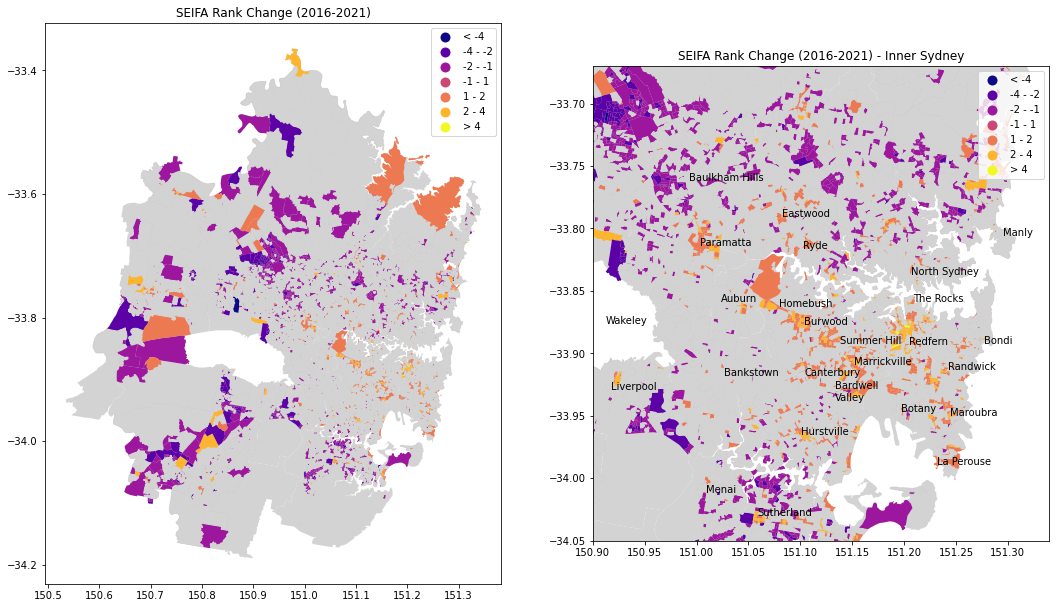

In [43]:
# Visualise SIEFA Rank Change coverage
figure, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 12))

gdf_sa3_syd.plot(color='lightgrey', ax=axes[0])
sa1_lm_syd.plot(column='SEIFA_bins', cmap="plasma", ax=axes[0], legend=True)
sa1_lm_syd_sd1.plot(color='lightgrey', edgecolor='lightgrey', ax=axes[0])
ax=axes[0].set(title='SEIFA Rank Change (2016-2021)')

gdf_sa3_syd.plot(color='lightgrey', ax=axes[1])
sa1_lm_syd.plot(column='SEIFA_bins', cmap="plasma", ax=axes[1], legend=True)
sa1_lm_syd_sd1.plot(color='lightgrey', edgecolor='lightgrey', ax=axes[1])
ax=axes[1].set(title='SEIFA Rank Change (2016-2021) - Inner Sydney')
ax=axes[1].set_xlim([150.9, 151.34])
ax=axes[1].set_ylim([-34.05, -33.67])
ax=axes[1].text(151.152, -33.909, 'Marrickville'); ax=axes[1].text(151.277, -33.892, 'Bondi'); 
ax=axes[1].text(151.295, -33.806, 'Manly'); ax=axes[1].text(151.197, -33.947, 'Botany'); 
ax=axes[1].text(151.205, -33.893, 'Redfern'); ax=axes[1].text(151.133, -33.938, 'Bardwell\nValley');
ax=axes[1].text(151.104, -33.918, 'Canterbury'); ax=axes[1].text(151.103, -33.816, 'Ryde'); 
ax=axes[1].text(151.232, -33.989, 'La Perouse'); ax=axes[1].text(151.244, -33.950, 'Maroubra'); 
ax=axes[1].text(151.003, -33.814, 'Paramatta'); ax=axes[1].text(151.138, -33.892, 'Summer Hill'); 
ax=axes[1].text(151.059, -34.030, 'Sutherland'); ax=axes[1].text(151.101, -33.965, 'Hurstville'); 
ax=axes[1].text(150.918, -33.929, 'Liverpool'); ax=axes[1].text(151.207, -33.837, 'North Sydney'); 
ax=axes[1].text(151.009, -34.012, 'Menai'); ax=axes[1].text(150.993, -33.762, 'Baulkham Hills'); 
ax=axes[1].text(151.209, -33.859, 'The Rocks'); ax=axes[1].text(151.242, -33.913, 'Randwick');

ax=axes[1].text(151.026, -33.918, 'Bankstown'); ax=axes[1].text(151.0236, -33.859, 'Auburn');
ax=axes[1].text(151.082, -33.7904, 'Eastwood'); ax=axes[1].text(151.0796, -33.863, 'Homebush');
ax=axes[1].text(150.912, -33.876, 'Wakeley'); ax=axes[1].text(151.104, -33.877, 'Burwood');